#  Indexing and searching image based documents (using ColPali with Qdrant)

We can retrieve documents with images such as user guides or old scanned documents. We will use an embedding model for the documents and the queries that supports images. We will also tune the vector database to efficiently store and search these embedding vectors. 

Here are the steps:
* [Creating image collection index](#creating-image-collection-index)
* [Searching the image index](#searching-the-image-index)
* [Generating a reply based on the retrieved image](#generate-response-with-the-retrieved-images)

## Visual Improvements

In [1]:
from rich.console import Console
from rich_theme_manager import Theme, ThemeManager
import pathlib

theme_dir = pathlib.Path("themes")
theme_manager = ThemeManager(theme_dir=theme_dir)
dark = theme_manager.get("dark")

# Create a console with the dark theme
console = Console(theme=dark)

In [2]:
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

## Creating image collection index

### Converting PDF files into images

We don't want to rely on text extraction from the PDF files, and we want to focus on the visual aspects of the pages. 

In [3]:
import sys
!{sys.executable} -m pip install pdf2image

Defaulting to user installation because normal site-packages is not writeable


In [4]:
import os
from pdf2image import convert_from_path

def convert_pdfs_to_images(pdf_folder):
    # Check if folder exists
    if not os.path.exists(pdf_folder):
        print(f"Folder not found: {pdf_folder}")
        print(f"Current directory: {os.getcwd()}")
        print(f"Available folders: {os.listdir('.')}")
        return {}
    
    pdf_files = [f for f in os.listdir(pdf_folder) if f.endswith(".pdf")]
    
    if not pdf_files:
        print(f"No PDF files found in {pdf_folder}")
        return {}
    
    print(f"Found {len(pdf_files)} PDF(s): {pdf_files}")
    
    all_images = {}
    for doc_id, pdf_file in enumerate(pdf_files):
        pdf_path = os.path.join(pdf_folder, pdf_file)
        images = convert_from_path(
            pdf_path,
            poppler_path=r'C:\poppler\Library\bin'  # Windows path
        )
        all_images[pdf_file] = images
        print(f"Converted {pdf_file}: {len(images)} pages")
    
    return all_images


In [5]:
# all_images = convert_pdfs_to_images("data/ikea/")
all_images = convert_pdfs_to_images("data/shokz/")

Found 1 PDF(s): ['OpenRun Pro User Guide.pdf']
Converted OpenRun Pro User Guide.pdf: 8 pages


In [6]:
console.print(all_images)

{
    'OpenRun Pro User Guide.pdf': [
        <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=749x749 at 0x168FBF174D0>,
        <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=749x749 at 0x168FC0D5BD0>,
        <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=749x749 at 0x168FC0D5E50>,
        <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=749x749 at 0x168FC0CA190>,
        <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=749x749 at 0x168FC0CA2C0>,
        <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=749x749 at 0x168FC134CB0>,
        <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=749x749 at 0x168FBF87020>,
        <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=749x749 at 0x168FBF87570>
    ]
}

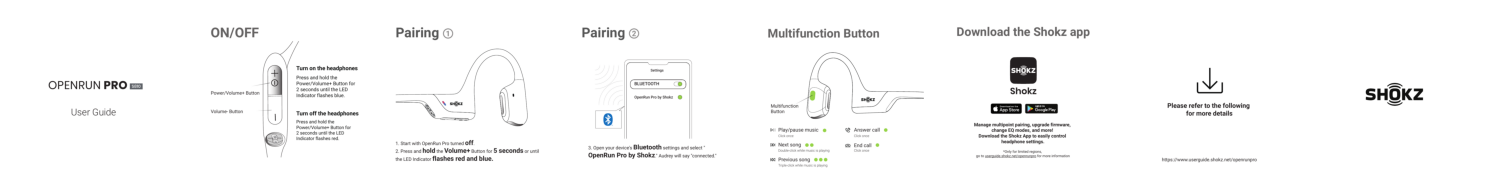

In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 8, figsize=(15, 10))

first_pdf_key = next(iter(all_images))
for i, ax in enumerate(axes.flat):
    img = all_images[first_pdf_key][i]
    ax.imshow(img)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [8]:
import sys
!{sys.executable} -m pip install colpali-engine

Defaulting to user installation because normal site-packages is not writeable


In [9]:
from colpali_engine.models import ColPali, ColPaliProcessor
import torch

# Initialize ColPali model and processor
model_name = "vidore/colpali-v1.2"

colpali_model = ColPali.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map="cpu",  # Windows: use "cpu" or "cuda:0" if you have NVIDIA GPU
)

colpali_processor = ColPaliProcessor.from_pretrained(
    "vidore/colpaligemma-3b-pt-448-base"
)

`torch_dtype` is deprecated! Use `dtype` instead!


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [10]:
console.print(colpali_model)

ColPali(
  (model): PaliGemmaForConditionalGeneration(
    (model): PaliGemmaModel(
      (vision_tower): SiglipVisionModel(
        (vision_model): SiglipVisionTransformer(
          (embeddings): SiglipVisionEmbeddings(
            (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
            (position_embedding): Embedding(1024, 1152)
          )
          (encoder): SiglipEncoder(
            (layers): ModuleList(
              (0-26): 27 x SiglipEncoderLayer(
                (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
                (self_attn): SiglipAttention(
                  (k_proj): Linear(in_features=1152, out_features=1152, bias=True)
                  (v_proj): Linear(in_features=1152, out_features=1152, bias=True)
                  (q_proj): Linear(in_features=1152, out_features=1152, bias=True)
                  (out_proj): Linear(in_features=1152, out_features=1152, bias=True)
                )
                (layer_norm2): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
                (mlp): SiglipMLP(
                  (activation_fn): GELUTanh()
                  (fc1): Linear(in_features=1152, out_features=4304, bias=True)
                  (fc2): Linear(in_features=4304, out_features=1152, bias=True)
                )
              )
            )
          )
          (post_layernorm): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
        )
      )
      (multi_modal_projector): PaliGemmaMultiModalProjector(
        (linear): Linear(in_features=1152, out_features=2048, bias=True)
      )
      (language_model): GemmaModel(
        (embed_tokens): Embedding(257216, 2048, padding_idx=0)
        (layers): ModuleList(
          (0-17): 18 x GemmaDecoderLayer(
            (self_attn): GemmaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora.Linear(
                (base_layer): Linear(in_features=2048, out_features=256, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=256, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (v_proj): lora.Linear(
                (base_layer): Linear(in_features=2048, out_features=256, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=256, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (o_proj): lora.Linear(
                (base_layer): Linear(in_featur

In [11]:
sample_image = all_images[first_pdf_key][0]
with torch.no_grad():
    sample_batch = colpali_processor.process_images([sample_image]).to(
        colpali_model.device
    )
    sample_embedding = colpali_model(**sample_batch)

In [12]:
console.print(sample_embedding)

tensor([[[ 0.0557,  0.0066,  0.0728,  ...,  0.0201,  0.0557, -0.0640],
         [-0.0381,  0.0908,  0.2354,  ...,  0.0151, -0.1045, -0.0292],
         [ 0.0469,  0.0659,  0.1455,  ...,  0.1670, -0.0254,  0.1079],
         ...,
         [ 0.0396, -0.0635,  0.0505,  ..., -0.0271, -0.1099,  0.0752],
         [-0.0752,  0.0498,  0.1250,  ...,  0.0393, -0.0962,  0.0220],
         [-0.0297,  0.1260,  0.2852,  ...,  0.0400, -0.0366, -0.0016]]],
       dtype=torch.bfloat16)

In [13]:
from rich.table import Table

table = Table(title="Document Embedding")
table.add_column("Documents", style="cyan", no_wrap=True)
table.add_column("Tokens", style="bright_yellow")
table.add_column("Vector Size", style="green")

table.add_row(
    str(sample_embedding.shape[0]), 
    str(sample_embedding.shape[1]), 
    str(sample_embedding.shape[2])
)

console.print(table)

         Document Embedding         
┏━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Documents ┃ Tokens ┃ Vector Size ┃
┡━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━┩
│ 1         │ 1031   │ 128         │
└───────────┴────────┴─────────────┘

In [14]:
from qdrant_client import QdrantClient

qdrant_client = QdrantClient(
    ":memory:"
)  # Use ":memory:" for in-memory database or "path/to/db" for persistent storage

In [15]:
vector_size = sample_embedding.shape[2]

In [16]:
from qdrant_client.http import models

multi_vector_params = models.VectorParams(
    size=vector_size,
    distance=models.Distance.COSINE,
    multivector_config=models.MultiVectorConfig(
        comparator=models.MultiVectorComparator.MAX_SIM
    ),
)

### Reducing vector memory using Quantization

We can define a `ScalarQuantizationConfig` and pass it when creating the collection. On the server side, Qdrant will convert the vectors to 8-bit integers, reducing the memory footprint and speeding up the search process. You can also switch on or off the `always_ram` parameter, keeping the vectors in RAM. This will increase performance at the cost of memory usage.

In [17]:
scalar_quant = models.ScalarQuantizationConfig(
    type=models.ScalarType.INT8,
    quantile=0.99,
    always_ram=False,
)

In [18]:
collection_name="user-guides"

qdrant_client.recreate_collection(
    collection_name=collection_name,  # the name of the collection
    on_disk_payload=True,  # store the payload on disk
    optimizers_config=models.OptimizersConfigDiff(
        indexing_threshold=100
    ),  # it can be useful to swith this off when doing a bulk upload and then manually trigger the indexing once the upload is done
    vectors_config=models.VectorParams(
        size=vector_size,
        distance=models.Distance.COSINE,
        multivector_config=models.MultiVectorConfig(
            comparator=models.MultiVectorComparator.MAX_SIM
        ),
        quantization_config=models.ScalarQuantization(
            scalar=scalar_quant,
        ),
    ),
)

True

### Upserting the encoded images into the vector database

We define a helper function to upload points to Qdrant via the client. We use the stamina library to enable retries in case of network issues 

In [19]:
import sys
!{sys.executable} -m pip install stamina

Defaulting to user installation because normal site-packages is not writeable


In [20]:
import stamina

@stamina.retry(on=Exception, attempts=3)
def upsert_to_qdrant(batch):
    try:
        qdrant_client.upsert(
            collection_name=collection_name,
            points=batch,  # Fix: use batch not points
            wait=False,
        )
    except Exception as e:
        print(f"Error during upsert: {e}")
        return False
    return True

We will now upload the vectors to qdrant. We do this by creating batches of data, passing it through the ColPali model and then adding the embeddings to a Qdrant `PointStruct`. 

In [ ]:
import uuid
from tqdm import tqdm

batch_size = 2  # Adjust based on your GPU memory constraints

total_images = sum(len(images) for images in all_images.values())

# Use tqdm to create a progress bar
with tqdm(total=total_images, desc="Indexing Progress") as pbar:
    for doc_id, pdf_file in enumerate(all_images.keys()):
        for i in range(0, len(all_images[pdf_file]), batch_size):
            images = all_images[pdf_file][i : i + batch_size]

            # Process and encode images
            with torch.no_grad():
                batch_images = colpali_processor.process_images(images).to(
                    colpali_model.device
                )
                image_embeddings = colpali_model(**batch_images)

            # Prepare points for Qdrant
            points = []
            for j, embedding in enumerate(image_embeddings):
                unique_id = str(uuid.uuid5(uuid.NAMESPACE_DNS, f"{doc_id}.{i + j}"))
                # Convert the embedding to a list of vectors
                multivector = embedding.cpu().float().numpy().tolist()
                points.append(
                    models.PointStruct(
                        id=unique_id,  
                        vector=multivector,  # This is now a list of vectors
                        payload={
                            "doc": pdf_file, 
                            "page": i+j+1
                        },  # can also add other metadata/data
                    )
                )
            # Upload points to Qdrant
            try:
                upsert_to_qdrant(points)
            # clown level error handling here 🤡
            except Exception as e:
                print(f"Error during upsert: {e}")
                continue

            # Update the progress bar
            pbar.update(batch_size)

print("Indexing complete!")

Indexing Progress:   0%|                                                                         | 0/8 [00:00<?, ?it/s]

If you had the indexing off during the upload you can trigger an index by setting a lower indexing threshold.

In [ ]:
qdrant_client.update_collection(
    collection_name=collection_name,
    optimizer_config=models.OptimizersConfigDiff(indexing_threshold=10),
)

In [ ]:
console.print( 
    qdrant_client
    .get_collection(collection_name)
)

In [ ]:
console.print(
    qdrant_client
    .scroll(
        collection_name=collection_name, 
        limit=20
    )
)

## Searching the image index

Once we uploaded the encoded images to the vector database, we can query it.

In [ ]:
# query_text = "How do I answer a call?"
query_text = "Why the led is flashing red and blue?"
with torch.no_grad():
    batch_query = colpali_processor.process_queries([query_text]).to(
        colpali_model.device
    )
    query_embedding = colpali_model(**batch_query)


In [ ]:
console.print(query_embedding.shape)

In [ ]:
# Convert the query embedding to a list of vectors
multivector_query = query_embedding[0].cpu().float().numpy().tolist()

In [ ]:
search_result = qdrant_client.query_points(
    collection_name=collection_name, 
    query=multivector_query, 
    limit=3, 
    timeout=60,
)

In [ ]:
console.print(search_result)

### Show the search results images

We can display the images that were retrieved by the vector search.

In [ ]:
import matplotlib.pyplot as plt

# Extract the top 3 images from the search result for display
top_images = search_result.points[:6]

# Create a figure with subplots for each image
fig, axs = plt.subplots(1, 3, figsize=(15, 10))

# Iterate over the top images and plot each one
for i, point in enumerate(top_images):
    pdf_file = point.payload.get('doc')
    page_num = int(point.payload.get('page')) - 1
    img = all_images[pdf_file][page_num]
    axs[i].imshow(img)
    axs[i].set_title(f"Score: {point.score}, \n Doc: {pdf_file}")
    axs[i].axis('off')  # Do not display axes for better visualization

plt.tight_layout()
plt.show()

## Generate response with the retrieved image(s)

In the **A**ugmentation step we encode the retrieved image using base64 and send it as part of the prompt to the generation model, alongside the user's query.

In [ ]:
import base64
from io import BytesIO

top_image = search_result.points[0]
pdf_file = top_image.payload.get('doc')
page_num = int(top_image.payload.get('page')) - 1
image = all_images[pdf_file][page_num]
display(image)

buffered = BytesIO()
image.save(buffered, format="PNG")  # You may choose another format if needed
img_bytes = buffered.getvalue()

image1_media_type = "image/png"

image1_data = base64.standard_b64encode(img_bytes).decode("utf-8")

In [ ]:
from dotenv import load_dotenv

load_dotenv()

In [ ]:
import anthropic

client = anthropic.Anthropic()
message = client.messages.create(
    model="claude-3-5-sonnet-20241022",
    max_tokens=1024,
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "source": {
                        "type": "base64",
                        "media_type": image1_media_type,
                        "data": image1_data,
                    },
                },
                {
                    "type": "text",
                    "text": query_text
                }
            ],
        }
    ],
)
console.print(message)
